<a href="https://colab.research.google.com/github/edofreeg/recommendation_systems/blob/main/Recommender_System_using_MovieLens_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and dataset

In [ ]:
%%capture
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install sentence-transformers

In [ ]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from operator import itemgetter
from sklearn import metrics,preprocessing
import operator

import sentence_transformers
from sentence_transformers import SentenceTransformer

import torch_geometric
import torch_geometric.data as dt
from torch_geometric.data import HeteroData, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
import torch_geometric.utils as U
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero, GATConv

import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%%capture
# download the dataset from MovieLens database
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

In [ ]:
# creating the two dataset 
ratings = pd.read_csv(rating_path)
movies= pd.read_csv(movie_path)

# Cleaning and processing data

In [ ]:
ratings=pd.merge(ratings,movies,on='movieId')
ratings.drop('timestamp', axis=1, inplace=True)

# filter the dataset setting the minimum rating and minimum number of rating per movie
ratings = ratings[ratings['rating']>= 0.5]
ratings = ratings[ratings.groupby("movieId")['rating'].transform('size') > 20]
ratings.rating=ratings.rating*2

In [ ]:
# apply the filter through the movie dataframe
movies=movies[movies.movieId.isin(ratings.movieId)]

In [ ]:
# encoding userId and movieId
movie_mapping = {idx: i for i, idx in enumerate(movies['movieId'].unique())} 
user_mapping = {idx: i for i, idx in enumerate(ratings['userId'].unique())}
ratings.replace({'userId': user_mapping},inplace=True)
ratings.replace({'movieId': movie_mapping},inplace=True)
movies.replace({'movieId': movie_mapping},inplace=True)
movies.reset_index( inplace=True)
movies.drop('index', axis=1, inplace=True)
ratings.drop('genres', axis=1, inplace=True)

In [ ]:
ratings.head()

,userId,movieId,rating,title
0,0,0,8.0,Toy Story (1995)
1,1,0,8.0,Toy Story (1995)
2,2,0,9.0,Toy Story (1995)
3,3,0,5.0,Toy Story (1995)
4,4,0,9.0,Toy Story (1995)


In [ ]:
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Father of the Bride Part II (1995),Comedy
4,4,Heat (1995),Action|Crime|Thriller


# Exploratory Data Analysis

In [ ]:
# create the utility matrix 
interaction_matrix = ratings.pivot_table(index='userId',columns='title',values='rating',fill_value=0)

In [ ]:
# spacity of interaction matrix
sparcity = 1-(len(ratings.rating)/(np.shape(interaction_matrix)[0]*np.shape(interaction_matrix)[1]))
print(f'The spacity of interaction matrix is {round(sparcity*100,2)}%')

The spacity of interaction matrix is 91.15%


In [ ]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))


The ratings dataset has 610 unique users
The ratings dataset has 1235 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


## Movies's statistic

In [ ]:
# Aggregate mean rating and number of reviews by movie
agg_movie_ratings = ratings.groupby('title').agg(mean_rating = ('rating', 'mean'), number_of_ratings = ('rating', 'count')).reset_index()                                              

In [ ]:
# Top movies by average rating
agg_movie_ratings.sort_values(by='mean_rating', ascending=False).head(10)

,title,mean_rating,number_of_ratings
961,"Shawshank Redemption, The (1994)",8.858044,317
1051,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),8.666667,27
821,"Philadelphia Story, The (1940)",8.620690,29
624,Lawrence of Arabia (1962),8.600000,45
548,In the Name of the Father (1993),8.600000,25
520,Hoop Dreams (1994),8.586207,29
447,"Godfather, The (1972)",8.578125,192
488,Harold and Maude (1971),8.576923,26
654,Logan (2017),8.560000,25
389,Fight Club (1999),8.545872,218


The mean rating is 7.05
The median rating is 7.13


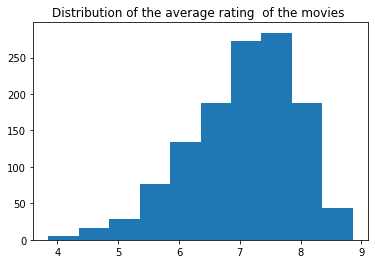

In [ ]:
# Distribution of the mean of the ratings of the movies
agg_movie_ratings.hist(column='mean_rating',grid=False)
pl.title("Distribution of the average rating  of the movies ")
print('The mean rating is',round(np.mean(agg_movie_ratings.mean_rating),2))
print('The median rating is',round(np.median(agg_movie_ratings.mean_rating),2))

In [ ]:
# Top movies by number of reviews
agg_movie_ratings.sort_values(by='number_of_ratings', ascending=False).head(10)

,title,mean_rating,number_of_ratings
412,Forrest Gump (1994),8.328267,329
961,"Shawshank Redemption, The (1994)",8.858044,317
862,Pulp Fiction (1994),8.394137,307
975,"Silence of the Lambs, The (1991)",8.322581,279
694,"Matrix, The (1999)",8.384892,278
1034,Star Wars: Episode IV - A New Hope (1977),8.462151,251
593,Jurassic Park (1993),7.500000,238
172,Braveheart (1995),8.063291,237
1077,Terminator 2: Judgment Day (1991),7.941964,224
939,Schindler's List (1993),8.450000,220


The mean number of ratings per movie is 54.0
The median number of ratings per movie is 40.0


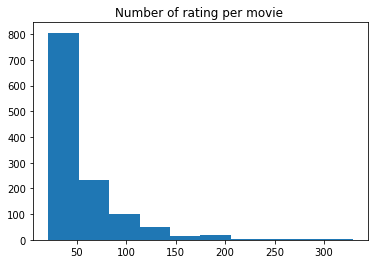

In [ ]:
# Distribution of the number of rating per movie
agg_movie_ratings.hist(column='number_of_ratings',grid=False)
pl.title("Number of rating per movie ")
print('The mean number of ratings per movie is',round(np.mean(agg_movie_ratings.number_of_ratings),0))
print('The median number of ratings per movie is',round(np.median(agg_movie_ratings.number_of_ratings),0))

In [ ]:
# function for single movie rating distribution

def movie_x_hist(movieid):
  if movieid <= (len(movie_mapping)+1):
    a=ratings[ratings.movieId==movieid].hist(column='rating', grid=False)
    pl.title(f"Ratings' distribution for {movies[movies.movieId==movieid]['title'].values[0]} ")
    return a

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87627377c0>]],
      dtype=object)

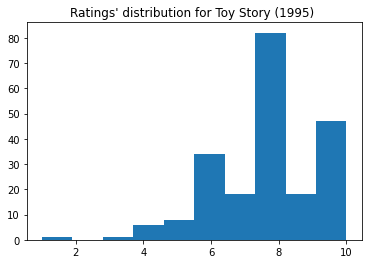

In [ ]:
movie_x_hist(0)

In [ ]:
# Proportion of movie's genres in the dataset

# matrix of movies genres
genres = movies['genres'].str.get_dummies('|').values
genres = torch.from_numpy(genres).to(torch.float)

# Normalized the genre of the movies
norm_fact=torch.sum(genres, dim=1)
norm_fact=norm_fact.reshape(1,-1).t()
norm_genres = genres / norm_fact

genres_count=torch.sum(norm_genres, dim=0)
norm_genres_count=genres_count/sum(genres_count)
label_genres = movies['genres'].str.get_dummies('|').columns

In [ ]:
# Number of genres
print(f'The dataset contains {len(label_genres)} genres ') 

The dataset contains 19 genres 


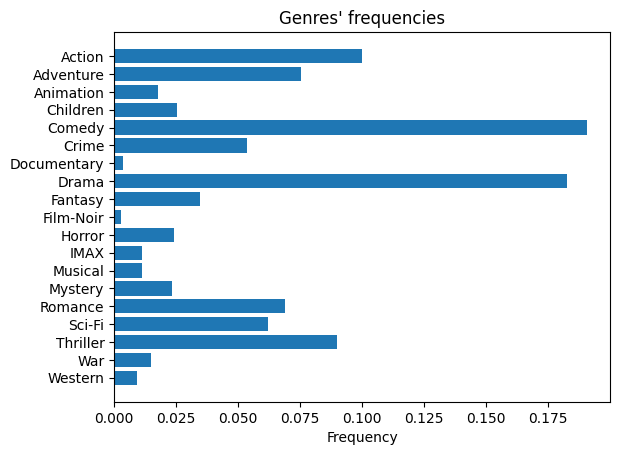

In [ ]:
# Bar plot of the movies' genres
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(label_genres,norm_genres_count)

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Frequency")
ax.set_title("Genres' frequencies")

plt.show()

In [ ]:
norm_genres_count

tensor([0.1000, 0.0752, 0.0178, 0.0254, 0.1905, 0.0536, 0.0035, 0.1825, 0.0348,
        0.0026, 0.0239, 0.0111, 0.0113, 0.0232, 0.0689, 0.0620, 0.0900, 0.0147,
        0.0091])

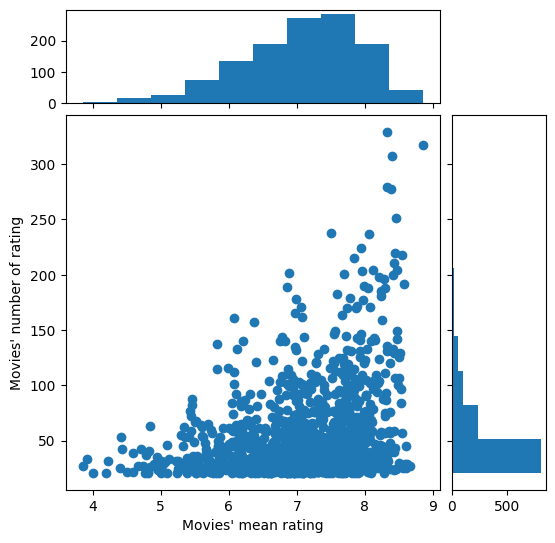

In [ ]:
# Movies mean rating vs Movies number of rating
x = agg_movie_ratings.mean_rating.values
y = agg_movie_ratings.number_of_ratings.values

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax.set_xlabel("Movies' mean rating")
    ax.set_ylabel("Movies' number of rating")

    ax_histx.hist(x )
    ax_histy.hist(y, orientation='horizontal')


fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)

## Users' statistic

In [ ]:
# user review 
agg_user_ratings = ratings.groupby('userId').agg(mean_rating = ('rating', 'mean'), number_of_ratings = ('rating', 'count')).reset_index()

In [ ]:
# Top 10 user with highest rating mean
agg_user_ratings.sort_values(by='mean_rating', ascending=False).head(10)

,userId,mean_rating,number_of_ratings
560,560,10.000000,14
386,386,9.950000,20
463,463,9.736842,19
305,305,9.714286,21
517,517,9.615385,26
373,373,9.523810,42
400,400,9.454545,33
528,528,9.362069,58
61,61,9.218750,64
286,286,9.206897,232


The average of the user's mean rating is 7.42
The average of the user's median rating is 7.48


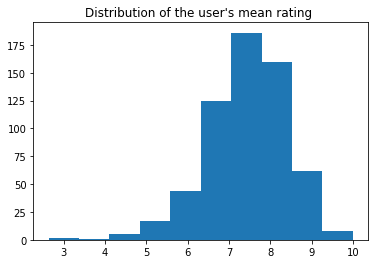

In [ ]:
# Distribution of the user's mean rating  
agg_user_ratings.hist(column='mean_rating',grid=False)
pl.title(f"Distribution of the user's mean rating ")
print("The average of the user's mean rating is",round(np.mean(agg_user_ratings.mean_rating),2))
print("The average of the user's median rating is",round(np.median(agg_user_ratings.mean_rating),2))

In [ ]:
# Top 10 user with highest number of reviews
agg_user_ratings.sort_values(by='number_of_ratings', ascending=False).head(10)

,userId,mean_rating,number_of_ratings
146,146,7.424299,1070
204,204,5.952484,926
23,23,6.515258,852
164,164,7.069061,724
98,98,6.804286,700
154,154,6.735931,693
135,135,7.930081,615
167,167,6.800000,590
106,106,6.785714,588
212,212,6.543890,581


The average of the user's number of ratings is  109.0
The median of the user's number of ratings is  56.0


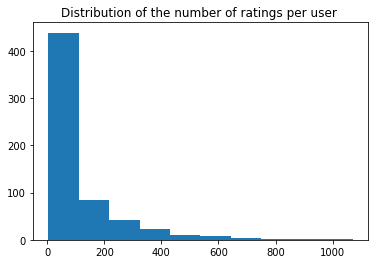

In [ ]:
# Distribution of the number of ratings per user
agg_user_ratings.hist(column='number_of_ratings',grid=False)
pl.title(f"Distribution of the number of ratings per user ")
print("The average of the user's number of ratings is ",round(np.mean(agg_user_ratings.number_of_ratings),0))
print("The median of the user's number of ratings is ",round(np.median(agg_user_ratings.number_of_ratings),0))

In [ ]:
# function for single user rating distribution
def user_x_hist(userid):
  if userid <= (len(user_mapping)-1):
     ratings_freq= Counter( ratings.rating[ratings.userId==userid])
     freq = list(ratings_freq.keys())
     frequencies = np.array(list(ratings_freq.values()))/len(ratings.rating[ratings.userId==userid])
     values = list(ratings_freq.values())
     fig, ax1 = plt.subplots()
     ax2 = ax1.twinx()

     ax1.bar(freq, values, color ="#348abd", width = 0.4)

     ax2.bar(freq, frequencies, color ='#348abd', width = 0.4)


     ax1.set_xlabel('Rating')
     ax1.set_ylabel('Count', color='Black')
     ax2.set_ylabel('Frequencies', color='b')
     plt.title(f"Movie's rating distribution for user {userid} with {len(ratings[ratings.userId==userid])} ratings")
     plt.xticks(freq)
     plt.show()
    


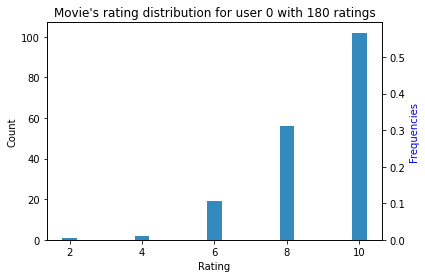

In [ ]:
user_x_hist(userid=0)

In [ ]:
# user 0 mean rating
np.mean(ratings.rating[ratings.userId==0])

8.844444444444445

In [ ]:
# user 0 median rating
np.median(ratings.rating[ratings.userId==0])

10.0

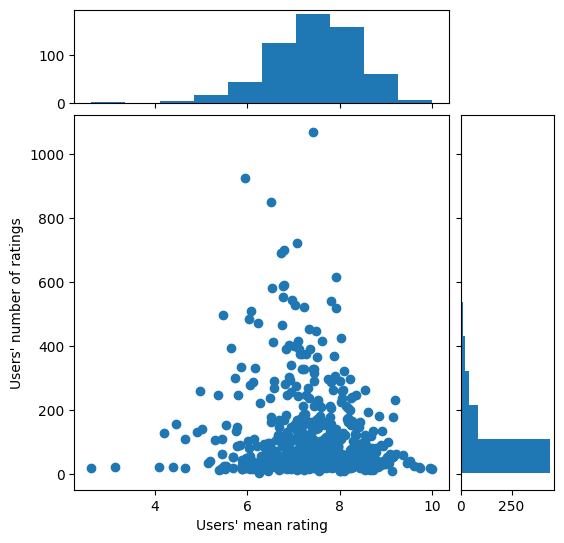

In [ ]:
# Users mean rating vs Users number of rating
x = agg_user_ratings.mean_rating.values
y = agg_user_ratings.number_of_ratings.values

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax.set_xlabel("Users' mean rating")
    ax.set_ylabel("Users' number of ratings")
    
    # now determine nice limits by hand:
    #binwidth = 0.25
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x )
    ax_histy.hist(y,  orientation='horizontal')

fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)






## Ratings' statistic

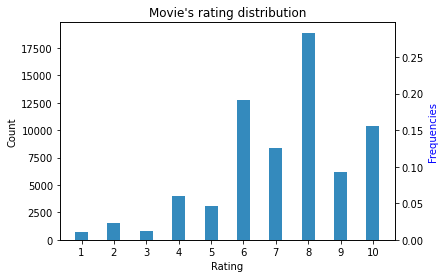

In [ ]:
# Bar plot of the rating distribution
ratings_freq= Counter(ratings.rating)
freq = list(ratings_freq.keys())
frequencies = np.array(list(ratings_freq.values()))/len(ratings.rating)
values = list(ratings_freq.values())

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(freq, values, color ="#348abd", width = 0.4)

ax2.bar(freq, frequencies, color ='#348abd', width = 0.4)


ax1.set_xlabel('Rating')
ax1.set_ylabel('Count', color='Black')
ax2.set_ylabel('Frequencies', color='b')
plt.title("Movie's rating distribution")
plt.xticks(freq)
plt.show()

# Recommender system

## Content based recommander system

In [ ]:
# Proportion of movie's genres in the dataset

# matrix of movies genres
genres = movies['genres'].str.get_dummies('|').values
genres = torch.from_numpy(genres).to(torch.float)


In [ ]:
# Content based model

'''
The model's paramerts are: userid -> the User id of the user in the rating dataset
                           k -> number of movies to correlate
The output of the function is: the k recommend movies   
                               the profile score of the user userid                       
'''

def user_x_rating(userid,k=10):
  if userid <= (len(user_mapping)-1) and userid >= 0:
    # rating of the movies saw
    rating_array=np.array(ratings.rating[ratings.userId==userid]).reshape(-1, 1)

    # rating of the movies saw
    view_movie_matrix=genres[np.array(ratings.movieId[ratings.userId==userid])] 

    # index of unseen movie
    indices_of_non_seen_movie=np.array(list(set(movies['movieId'].values) - set(ratings.movieId[ratings.userId==userid].values)))

    # matrix of the feature of NON reviewed movies
    non_view_movie_matrix=genres[indices_of_non_seen_movie] 

    # score of the user's preference
    user_score =torch.sum(torch.tensor(rating_array) * view_movie_matrix,dim=0)/sum(torch.sum(torch.tensor(rating_array) * view_movie_matrix,dim=0))

    # estimated score of the unseen movie
    score_non_rew_movie= torch.sum(user_score*non_view_movie_matrix,dim=1).numpy()
    
    # take the indices in the vector of unseen movie
    ind = np.argsort(score_non_rew_movie)[::-1][:k]

    # the indices is reverse in the list of unseen movie
    movie_not_seen=indices_of_non_seen_movie[ind] 
    
    # dataframe contains the score of the user
    data_dict={'genre':movies['genres'].str.get_dummies('|').columns, 'score':np.around(user_score.numpy(),4)}
    ret_data= pd.DataFrame(data=[movies.title.loc[movie_not_seen].values.T,score_non_rew_movie[ind].T]).T
    ret_data.columns = ['movie_title','score']
    
    return  ret_data , pd.DataFrame(data=data_dict) # the index  unseen movie is match in the list of whole movies in order to get the title
  else:
    raise IndexError(f"The userId doens't exist. the userId range is from 0 to  {max(ratings.userId)} ")




In [ ]:
recsys, profile_score =user_x_rating(0,k=10)

In [ ]:
recsys

,movie_title,score
0,Super Mario Bros. (1993),0.569102
1,Sherlock Holmes: A Game of Shadows (2011),0.567432
2,Charlie's Angels: Full Throttle (2003),0.539875
3,The Lego Movie (2014),0.53737
4,Blood Diamond (2006),0.536952
5,Hancock (2008),0.519415
6,Three Kings (1999),0.513987
7,Children of Men (2006),0.510647
8,Jurassic World (2015),0.510647
9,"Day After Tomorrow, The (2004)",0.510647


In [ ]:
profile_score

,genre,score
0,Action,0.1374
1,Adventure,0.1265
2,Animation,0.0338
3,Children,0.0497
4,Comedy,0.1265
5,Crime,0.0656
6,Documentary,0.0000
7,Drama,0.0973
8,Fantasy,0.0635
9,Film-Noir,0.0021


## Collaboratory filtering 

### item-item collaborative filtering

In [ ]:
# Recommendation model that is based on the ratings similarity of the movies

In [ ]:
# creating the interaction (utility) matrix R
interaction_matrix= pd.pivot_table( data=ratings,index='title', columns='userId', values='rating' ) 

In [ ]:
# Item similarity matrix using Pearson correlation
item_similarity = interaction_matrix.T.corr()

In [ ]:
# Item-based recommendation function
def item_based_rec(picked_userid, number_of_similar_items=5, number_of_recommendations =10):
  # Movies that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(interaction_matrix[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[picked_userid]==True]['title'].values.tolist()
  # Movies that the target user has watched
  picked_userid_watched = pd.DataFrame(interaction_matrix[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={picked_userid:'rating'})
  
  # Dictionary to save the unwatched movie and predicted rating pair
  rating_prediction ={}  
  # Loop through unwatched movies          
  for picked_movie in picked_userid_unwatched: 
    # Calculate the similarity score of the picked movie with other movies
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                                right=picked_movie_similarity_score, 
                                                on='title', 
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                        weights=picked_userid_watched_similarity['similarity_score']), 2)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_movie] = predicted_rating
    # Return the top recommended movies
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

In [ ]:
item_based_rec(picked_userid=0,number_of_similar_items=11, number_of_recommendations =10)

[('Lethal Weapon 4 (1998)', 10.0),
 ('Untouchables, The (1987)', 10.0),
 ('Babel (2006)', 9.84),
 ('Ghost in the Shell (Kôkaku kidôtai) (1995)', 9.84),
 ('Pianist, The (2002)', 9.84),
 ('Waiting for Guffman (1996)', 9.84),
 ('Fistful of Dollars, A (Per un pugno di dollari) (1964)', 9.83),
 ('Godfather: Part III, The (1990)', 9.83),
 ('Maverick (1994)', 9.83),
 ('Vanilla Sky (2001)', 9.83)]

### user-user collaborative filtering

In [ ]:
# Recommendation model that is based on the ratings  of the most similar users to the selected one

In [ ]:
# create the interaction matrix
interaction_matrix = ratings.pivot_table(index='userId',columns='title',values='rating',fill_value=0)

In [ ]:
# create matrix of users similarity
similarity_dataframe=interaction_matrix.T.corr()

In [ ]:
# User-user collaborative filtering

'''
The parameters of the model are: userid -> the user Id for wich we want the recommendation 
                                 min_cor -> the minimum correlation of user id with other user
                                 num_movie -> number of movie to be correlated
The output of the function is a dataframe with the moives' title column and the expected rating column
'''


def user_user_model(userid,min_cor=0.1,num_movie=10):
  if userid <= (len(user_mapping)-1) and userid >= 0:

    # create the array of userid with the correlattion with the other user
    neighbor_x= np.array([similarity_dataframe[userid].index[i] for i, v in enumerate(similarity_dataframe[userid]) if v>=min_cor])
    # remove the userid from the correlated users
    neighbor_x= list(neighbor_x)
    neighbor_x.remove(userid)

    if len(neighbor_x) < 1:
      return print(f' There is no users correlated at {min_cor*100}% level ')


    # find the non reviwed movies of the user
    recomendation_columns= np.where(interaction_matrix.iloc[userid] == 0)[0]

    # find the neighbors rating for the movies non rated by the userid
    neighbor_rating =interaction_matrix.iloc[neighbor_x, recomendation_columns ] 

    # find the correlation values of the neighbors with userid
    neighbor_similarity= similarity_dataframe[userid].loc[neighbor_x]
    
    # estimate the user rating non rated bat userid 
    score = np.dot(neighbor_similarity, neighbor_rating)/sum(neighbor_similarity) 

    # creating the output dataframe 
    datumm = score
    columns = neighbor_rating.columns
    item_score_df=pd.DataFrame(data=[columns,datumm.T]).T
    item_score_df.columns = ['movie_title','score']
    item_score_df.sort_values(by='score',  axis=0, ascending=False, inplace=True)

    return item_score_df.head(num_movie)  

  else:
    raise IndexError(f"The userId doens't exist. The userId range is from 0 to  {max(ratings.userId)} ")

In [ ]:
user_user_model(userid=0,min_cor=0.2 ,num_movie=10)

,movie_title,score
382,"Godfather, The (1972)",7.014163
920,Terminator 2: Judgment Day (1991),6.982508
40,Aliens (1986),6.956132
269,Die Hard (1988),6.06848
494,Jaws (1975),5.548417
843,"Sixth Sense, The (1999)",5.52623
383,"Godfather: Part II, The (1974)",5.395539
978,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),5.187547
873,Stand by Me (1986),5.083041
824,"Shawshank Redemption, The (1994)",5.082163


## Latent based recommender system

### Create the bipartite graph

In [ ]:
%%capture
torch_geometric.seed_everything(5007662)
# embedding of movie's title
model = SentenceTransformer("all-MiniLM-L6-v2")
with torch.no_grad():
  emb = model.encode(movies['title'].values, show_progress_bar=True,convert_to_tensor=True).cpu()
  
# encoding movie's genre
genres = movies['genres'].str.get_dummies('|').values
genres = torch.from_numpy(genres).to(torch.float)

In [ ]:
# creating heterogeneus graph

data = HeteroData()

data['movie'].num_nodes = len(movie_mapping)
data['user'].num_nodes = len(user_mapping)

data['movie'].x = torch.cat([emb,genres], dim=-1)
data['user'].x = torch.eye(data['user'].num_nodes) # no infomatio a priori about the  users

src = ratings['userId'].values
dst = ratings['movieId'].values

edge=[]
for i in list(range(0,len(src))):
  edge.append( [src[i],dst[i]])

edge_index= torch.tensor(edge)
edge_index=edge_index.t().contiguous()

rating = torch.from_numpy(ratings['rating'].values).to(torch.long)
data['user', 'rates', 'movie'].edge_label = rating

data['user', 'rates', 'movie'].edge_index = edge_index

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)

# Remove "reverse" label.
del data['movie', 'rev_rates', 'user'].edge_label  

In [ ]:
torch_geometric.seed_everything(seed=5007662) # set seed
# Perform a link-level split into training (80%) and test (20%) edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.2,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')]
)(data)

### Randomly initialize matrix factorization

In [ ]:
interaction_matrix = pd.pivot_table( data=ratings,index=['userId'], columns=['movieId'],values= 'rating',fill_value=0 ) 

In [ ]:
# Sort our data usa gli edges del grafo

train_rows=train_data['user', 'rates', 'movie'].edge_label_index[0].numpy()
train_cols=train_data['user', 'rates', 'movie'].edge_label_index[1].numpy()

test_rows=test_data['user', 'rates', 'movie'].edge_label_index[0].numpy()
test_cols=test_data['user', 'rates', 'movie'].edge_label_index[1].numpy()


In [ ]:
# setting hyperparameter
latent_vectors = 16 # dimension of the embedding
num_users =  max(ratings.userId)+1
num_movies= max(ratings.movieId)+1

In [ ]:
#randomly initialized moedel
class LR_Matrix_Factorization(torch.nn.Module):
    def __init__(self,user_features, movie_features):
        super().__init__()
        self.u_features=user_features
        self.v_features=movie_features

    def forward(self, rows,cols):
        z=torch.matmul( self.u_features, self.v_features.t()).relu()
        z= z[rows, cols]
        
        return z, self.u_features[rows], self.v_features[cols]

In [ ]:
# inizialization of the embedding randomly
user_features = torch.randn(num_users, latent_vectors, requires_grad=True, device=device)
movie_features = torch.randn(num_movies, latent_vectors, requires_grad=True, device=device)


# model initialization
model = LR_Matrix_Factorization(user_features=user_features,movie_features= movie_features) 
optimizer = torch.optim.Adam([user_features, movie_features], lr=0.01)


In [ ]:
# definig the loss function 
def weighted_mse_loss(pred, target,u_features, v_features, lam_u=0.3,lam_v=0.3):
  ssr= (torch.sum(torch.square(pred - target)))
  u_regularization = lam_u * torch.sum(torch.pow(u_features.norm(dim=1), 2))
  v_regularization = lam_v * torch.sum(torch.pow(v_features.norm(dim=1), 2))

  return (ssr+u_regularization+v_regularization)/2

In [ ]:
# defining the train function
def train():
    model.train()
    optimizer.zero_grad()
    pred,user_features,movie_features = model(rows=train_rows,cols=train_cols)
    target =  torch.from_numpy(interaction_matrix.values[train_rows,train_cols]).to(device)
    loss = weighted_mse_loss(pred, target,u_features=user_features, v_features=movie_features)
    loss.backward()
    optimizer.step()
    return float(loss)


In [ ]:
# defining the test function to evaluate the mean square error
@torch.no_grad()
def test(rows,cols):
    model.eval()
    pred,user_features,movie_features = model(rows=rows,cols=cols)
    pred = pred.clamp(min=1, max=10)
    target =  torch.from_numpy(interaction_matrix.values[rows,cols]).to(device)
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [ ]:
ran_loss_time_series=[]
ran_train_rmse_time_series=[]
ran_test_rmse_time_series=[]

In [ ]:
# run the model 
for epoch in range(1,1000):
    loss = train()
    train_rmse = test(train_rows,train_cols)
    test_rmse = test(test_rows,test_cols)

    ran_loss_time_series.append(loss)
    ran_train_rmse_time_series.append(train_rmse)
    ran_test_rmse_time_series.append(test_rmse)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train RMSE: {train_rmse:.4f},Test RMSE: {test_rmse:.4f}') 


Epoch: 001, Loss: 1370941.5000, Train RMSE: 5.8399,Test RMSE: 5.8611
Epoch: 002, Loss: 1364563.7500, Train RMSE: 5.8289,Test RMSE: 5.8613
Epoch: 003, Loss: 1358315.5000, Train RMSE: 5.8176,Test RMSE: 5.8613
Epoch: 004, Loss: 1352185.1250, Train RMSE: 5.8060,Test RMSE: 5.8613
Epoch: 005, Loss: 1346176.8750, Train RMSE: 5.7941,Test RMSE: 5.8612
Epoch: 006, Loss: 1340281.6250, Train RMSE: 5.7818,Test RMSE: 5.8609
Epoch: 007, Loss: 1334496.5000, Train RMSE: 5.7693,Test RMSE: 5.8605
Epoch: 008, Loss: 1328822.7500, Train RMSE: 5.7566,Test RMSE: 5.8600
Epoch: 009, Loss: 1323241.5000, Train RMSE: 5.7437,Test RMSE: 5.8592
Epoch: 010, Loss: 1317733.6250, Train RMSE: 5.7306,Test RMSE: 5.8583
Epoch: 011, Loss: 1312302.5000, Train RMSE: 5.7174,Test RMSE: 5.8572
Epoch: 012, Loss: 1306947.7500, Train RMSE: 5.7040,Test RMSE: 5.8560
Epoch: 013, Loss: 1301661.1250, Train RMSE: 5.6905,Test RMSE: 5.8545
Epoch: 014, Loss: 1296442.6250, Train RMSE: 5.6769,Test RMSE: 5.8528
Epoch: 015, Loss: 1291281.5000, Tr

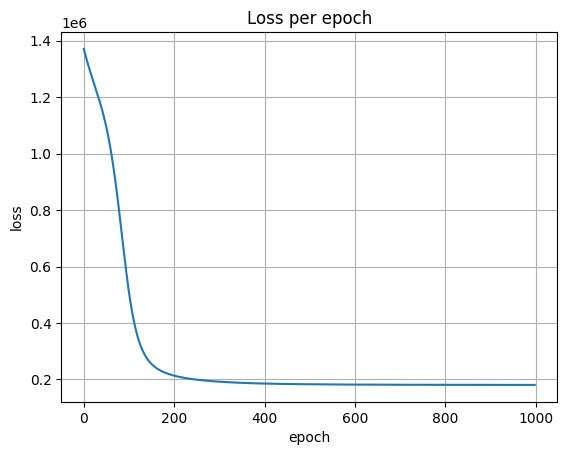

In [ ]:
# Plot the loss function
fig, ax = plt.subplots()
ax.plot(list(range(0,len(ran_loss_time_series))), ran_loss_time_series)
ax.set(xlabel='epoch', ylabel='loss',title='Loss per epoch')
ax.grid()
plt.show()

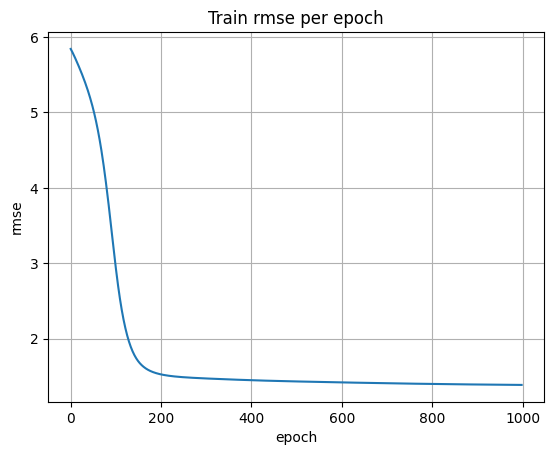

In [ ]:
# Plot the train root mean square error
fig, ax = plt.subplots()
ax.plot(list(range(0,len(ran_train_rmse_time_series))), ran_train_rmse_time_series)

ax.set(xlabel='epoch', ylabel='rmse',
       title='Train rmse per epoch')
ax.grid()


plt.show()

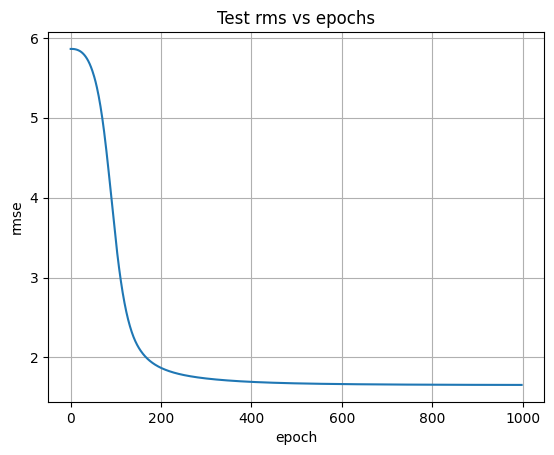

In [ ]:
# Plot the test root mean square error
fig, ax = plt.subplots()
ax.plot(list(range(0,len(ran_test_rmse_time_series))), ran_test_rmse_time_series)

ax.set(xlabel='epoch', ylabel='rmse',
       title='Test rms vs epochs')
ax.grid()


plt.show()

In [ ]:
print(f'After {epoch+1:03d} epochs, for the NN with random values initialization  the final loss  is: {loss:.4f}, the final train RMSE is: {train_rmse:.4f}, the final test RMSE is: {test_rmse:.4f} ')

After 1000 epochs, for the NN with random values initialization  the final loss  is: 180518.0938, the final train RMSE is: 1.3888, the final test RMSE is: 1.6567 


#### Analyzing the model's results

In [ ]:
# estimate the test rating values
model.eval()
pred,_,_ = model(rows=test_rows,cols=test_cols)
pred = pred.clamp(1,10)
true_values =interaction_matrix.values[test_rows,test_cols]

In [ ]:
# create a dictionary with key:userId and values: estimate rating and true rating
predicted_rating={}
for i , j, k  in zip(test_rows, true_values,pred):
  i= int(i) # userId
  j=float(j) #rating true
  k=int(round(float(k),0))# predicted rating 2
  userid=i
  if userid in predicted_rating.keys():
    predicted_rating[userid].append([k,j])
  else:
    predicted_rating[userid]=[[k,j]]

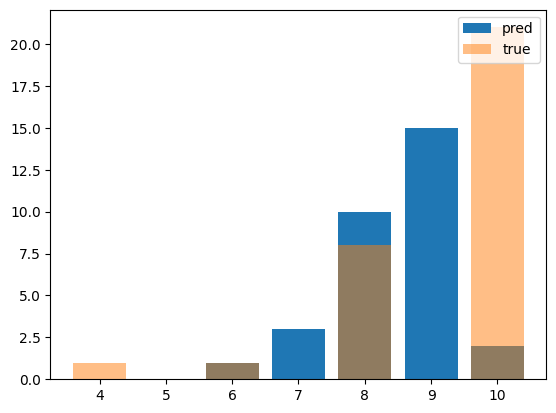

In [ ]:
#user 0 prediction vs actual rating
histo_test=[]
histo2_test=[]
for i in predicted_rating[0]:  
  histo_test.append(i[0])
  histo2_test.append(i[1])

count_test_pred=Counter(histo_test)
count_test_true=Counter(histo2_test)

keys_test_pred = count_test_pred.keys()
values_test_pred = count_test_pred.values()

keys_test_true = count_test_true.keys()
values_test_true = count_test_true.values()

plt.bar(keys_test_pred, values_test_pred,label='pred')
plt.bar(keys_test_true, values_test_true,alpha=0.5,label='true')
plt.legend(loc='upper right')

In [ ]:
# find the goodness of the model's predictions
count=[]
count_value=0
true_val= []
pred_val= []
for key, value in predicted_rating.items():
  count_value=0
  lenn=len(value)
  for i in value:
    if lenn >= 1:
      pred_val.append(i[0])
      true_val.append(i[1])


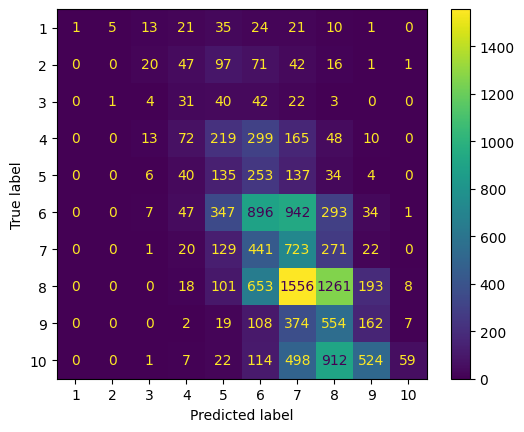

In [ ]:
# display the predictions vs true values for a visualization of the goodness of the model

confusion_matrix = metrics.confusion_matrix(true_val, pred_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1,2,3,4,5,6,7,8,9,10]) 
cm_display.plot()
plt.show()

#### Recommendation

In [ ]:
# find the coordinates of the non rated movies by users
coordinate_blank=np.argwhere(interaction_matrix.values==0)
coordinate_blank=np.transpose(coordinate_blank)
row_fill=coordinate_blank[0]
col_fill=coordinate_blank[1]

In [ ]:
# predict the ratings
model.eval()
pred,_,_ = model(rows=row_fill,cols=col_fill)

In [ ]:
# create a dictionary with key:userId and values: estimate rating and movieId
predicted_rating={}
for i , j, k  in zip(row_fill,col_fill,pred):
  userid= int(i)  # userId
  movieid=movies.title[movies.movieId==j].values[0]
  #movieid= movies.title[movies['movieId']==movieID].values[0] #movieId
  k=round(float(k),2)# predicted rating
  if userid in predicted_rating.keys():
    predicted_rating[userid].append([k,movieid])
  else:
    predicted_rating[userid]=[[k,movieid]]

In [ ]:
# sorting the estimate rating for the recommendation
for key, value in predicted_rating.items():
  predicted_rating[key]= sorted(predicted_rating[key], key=itemgetter(0),reverse=True)

In [ ]:
# function to find the movies to recommend to the user
'''
The function parameters are: userid -> is the user Id 
                             num_movie -> number of movies to recommend
The function retur the first k number of recommended movies
'''

def rand_matrix_fact_recsys(userid,num_movie):
  return predicted_rating[userid][0:num_movie]

In [ ]:
rand_matrix_fact_recsys(0,10)

[[10.15, 'Shawshank Redemption, The (1994)'],
 [10.01, 'Casablanca (1942)'],
 [10.01, 'Boondock Saints, The (2000)'],
 [9.83, 'Argo (2012)'],
 [9.8, 'Grand Day Out with Wallace and Gromit, A (1989)'],
 [9.73, 'For a Few Dollars More (Per qualche dollaro in più) (1965)'],
 [9.72, 'Departed, The (2006)'],
 [9.71, 'Godfather, The (1972)'],
 [9.65, 'Apartment, The (1960)'],
 [9.63, 'Gosford Park (2001)']]

### Graph neural network recommender systems

### GAT layer

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels,add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels,add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        
            
        return x    

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder( hidden_channels,hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum') 
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        

        return self.decoder(z_dict, edge_label_index)

In [ ]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

    def forward(self, z_dict, edge_label_index): # apply matrix factorization 
        row, col = edge_label_index
        z=torch.matmul( z_dict['user'], z_dict['movie'].t()).relu()
        z= z[row, col]

        
        return z.view(-1),z_dict['user'][row], z_dict['movie'][col]

In [ ]:
model = Model(hidden_channels=16)

# Generating the layer-0 (input layer) for the embedding of the nodes
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# definig the loss function 

def weighted_mse_loss(pred, target,user_emb, movie_emb, lambda_u=0.3,lambda_v=0.3):
  ssr= (pred - target.to(pred.dtype)).pow(2).sum()
  u_regularization = lambda_u * torch.sum(torch.pow(user_emb.norm(dim=1),2))
  v_regularization = lambda_v * torch.sum(torch.pow(movie_emb.norm(dim=1),2))

  return (ssr+u_regularization+v_regularization)/2

In [ ]:
# defining the train function
def train():
    model.train()
    optimizer.zero_grad()
    pred,user_emb,movie_emb = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target,user_emb=user_emb, movie_emb=movie_emb)
    loss.backward()
    optimizer.step()
    return float(loss)


In [ ]:
# defining the test function to evaluate the mean square error
@torch.no_grad()
def test(data):
    model.eval()
    pred,_,_ = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=1, max=10)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [ ]:
gat_loss_time_series=[]
gat_train_rmse_time_series=[]
gat_test_rmse_time_series=[]

In [ ]:
# run the model 
for epoch in range(1,1000):
    loss = train()
    train_rmse = test(train_data)
    test_rmse = test(test_data)

    gat_loss_time_series.append(loss)
    gat_train_rmse_time_series.append(train_rmse)
    gat_test_rmse_time_series.append(test_rmse)

    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train RMSE: {train_rmse:.4f},Test RMSE: {test_rmse:.4f}') 

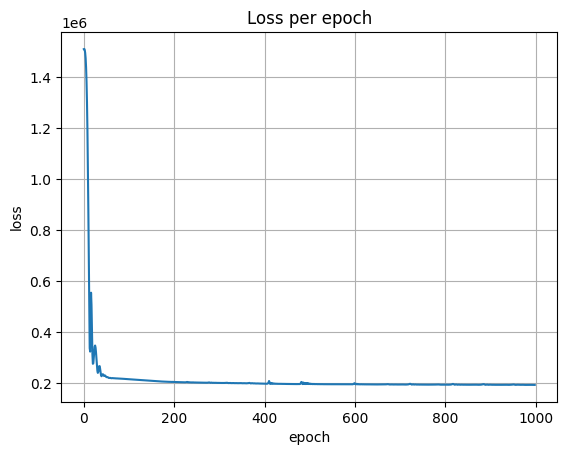

In [ ]:
# Plot the loss function
fig, ax = plt.subplots()
ax.plot(list(range(0,len(gat_loss_time_series))), gat_loss_time_series)
ax.set(xlabel='epoch', ylabel='loss',title='Loss per epoch')
ax.grid()
plt.show()

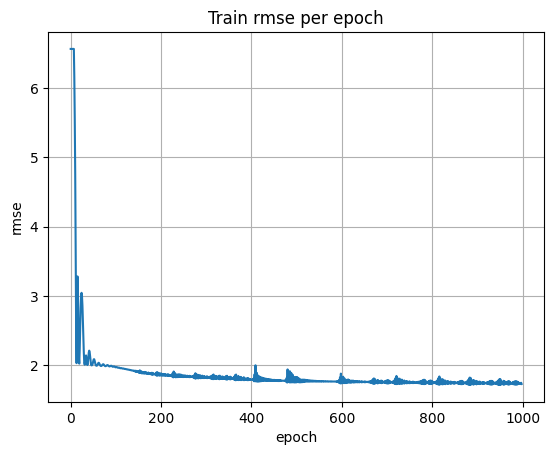

In [ ]:
# Plot the train root mean square error
fig, ax = plt.subplots()
ax.plot(list(range(0,len(gat_train_rmse_time_series))), gat_train_rmse_time_series)

ax.set(xlabel='epoch', ylabel='rmse',
       title='Train rmse per epoch')
ax.grid()


plt.show()

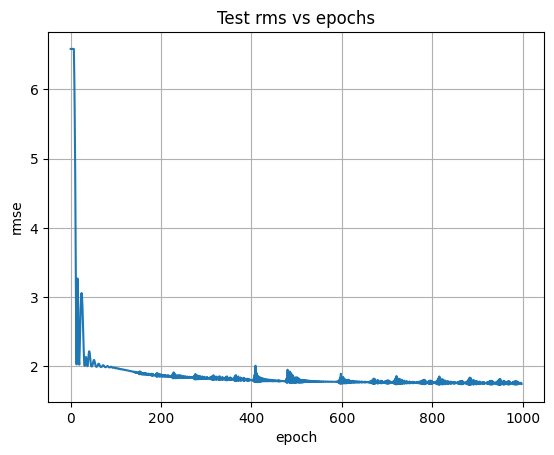

In [ ]:
# Plot the test root mean square error
fig, ax = plt.subplots()
ax.plot(list(range(0,len(gat_test_rmse_time_series))), gat_test_rmse_time_series)

ax.set(xlabel='epoch', ylabel='rmse',
       title='Test rms vs epochs')
ax.grid()


plt.show()

In [ ]:
print(f'After {epoch+1:04d},for the GNN with GAT layer the final loss is: {loss:.4f}, the final train RMSE is: {train_rmse:.4f}, the final test RMSE is: {test_rmse:.4f} ')

After 1000,for the GNN with GAT layer the final loss is: 193285.3438, the final train RMSE is: 1.7305, the final test RMSE is: 1.7482 


##### Analyzing the model's results

In [ ]:
# estimate the test rating values

model.eval()
pred,_,_ = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(1,10)

In [ ]:
# create a dictionary with key:userId and values: estimate rating and true rating

predicted_rating={}

for i , j, k  in zip(test_data['user', 'rates', 'movie'].edge_label_index[0],test_data['user', 'rates', 'movie'].edge_label,pred): # per nome film test_data['user', 'rates', 'movie'].edge_index[1]
  userid= int(i) # userId
  j=float(j) #rating true
  k=int(round(float(k),0))# predicted rating 
  #userid=list(user_mapping.keys())[list(user_mapping.values()).index(i)]
  if userid in predicted_rating.keys():
    predicted_rating[userid].append([k,j])
  else:
    predicted_rating[userid]=[[k,j]]

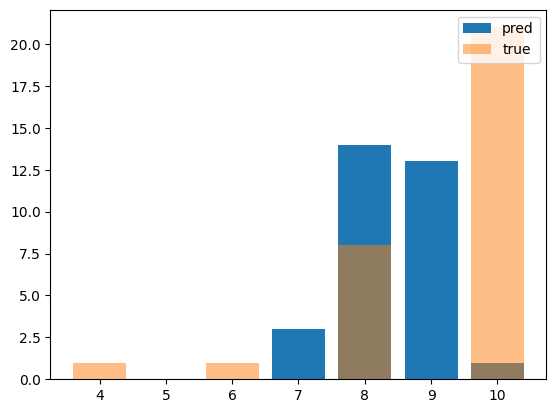

In [ ]:
#user 0 prediction vs actual rating
histo_test=[]
histo2_test=[]
for i in predicted_rating[0]:  #192
  histo_test.append(i[0])
  histo2_test.append(i[1])

count_test_pred=Counter(histo_test)
count_test_true=Counter(histo2_test)

keys_test_pred = count_test_pred.keys()
values_test_pred = count_test_pred.values()

keys_test_true = count_test_true.keys()
values_test_true = count_test_true.values()

plt.bar(keys_test_pred, values_test_pred,label='pred')
plt.bar(keys_test_true, values_test_true,alpha=0.5,label='true')
plt.legend(loc='upper right')


In [ ]:
# find the goodness of the predictions
count=[]
count_value=0
true_val= []
pred_val= []
for key, value in predicted_rating.items():
  count_value=0
  lenn=len(value)
  for i in value:
    if lenn >= 1:
      pred_val.append(i[0])
      true_val.append(i[1])


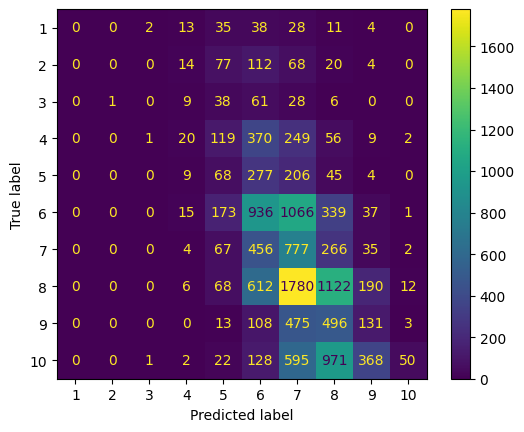

In [ ]:
# display the predictions vs true values for a visualization of the goodness of the model
confusion_matrix = metrics.confusion_matrix(true_val, pred_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1,2,3,4,5,6,7,8,9,10]) 
cm_display.plot()
plt.show()

##### Recommendation

In [ ]:
# find the coordinates of the non rated movies by users
interaction_matrix = pd.pivot_table( data=ratings,index=['userId'], columns=['movieId'],values= 'rating' ) 
coordinate_blank=np.argwhere(np.isnan(interaction_matrix.to_numpy()))
coordinate_blank=np.transpose(coordinate_blank)

In [ ]:
%%capture
# create the graph of the non connected edges
fill_data = HeteroData()

fill_data['movie'].num_nodes = len(movie_mapping)
fill_data['user'].num_nodes = len(user_mapping)


fill_data['movie'].x = torch.cat([emb, genres], dim=-1)
fill_data['user'].x = torch.eye(fill_data['user'].num_nodes)


src = coordinate_blank[0]
dst = coordinate_blank[1]

edge=[]
for i in list(range(0,len(src))):
  edge.append( [src[i],dst[i]])

edge_index= torch.tensor(edge)
edge_index=edge_index.t().contiguous()

fill_data['user', 'rates', 'movie'].edge_index = edge_index
rating = torch.zeros(len(coordinate_blank[0])).to(torch.long)

fill_data['user', 'rates', 'movie'].edge_label = rating

fill_data = T.ToUndirected()(fill_data)
del fill_data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

fill_data, fill_val_data, fill_test_data = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.0,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(fill_data)

In [ ]:
# function to find the estimate of the rating
def fill_blank_space(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,data['user', 'movie'].edge_label_index)
    return pred

In [ ]:
# actual estimation of the ratings
fill_data['user', 'rates', 'movie'].edge_label,_,_ = fill_blank_space(fill_data)

In [ ]:
# create a dictionary with key:userId and values: estimate rating and movieId
predicted_rating ={}
for i , j, k  in zip(fill_data['user', 'rates', 'movie'].edge_label_index[0],fill_data['user', 'rates', 'movie'].edge_label_index[1],fill_data['user', 'rates', 'movie'].edge_label):
  userid= int(i)  # userId
  movieid=int(j)
  movieid= movies.title[movies['movieId']==movieid].values[0] #movieId
  k=round(float(k),2)# predicted rating
  if userid in predicted_rating.keys():
    predicted_rating[userid].append([k,movieid])
  else:
    predicted_rating[userid]=[[k,movieid]]


In [ ]:
# sorting the estimate rating for the recommendation
for key, value in predicted_rating.items():
  predicted_rating[key]= sorted(predicted_rating[key], key=itemgetter(0),reverse=True)

In [ ]:
# function to find the movies to recommend to the user
'''
The function parameters are: userid -> is the user Id 
                             num_movie -> number of movies to recommend
'''

def rand_matrix_fact_recsys(userid,num_movie):
  return predicted_rating[userid][0:num_movie]

In [ ]:
rand_matrix_fact_recsys(0,10)

[[6.11, 'Bruce Almighty (2003)'],
 [6.07, 'Dirty Dancing (1987)'],
 [6.06, 'Hitch (2005)'],
 [6.06, 'Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002)'],
 [6.06, 'Rain Man (1988)'],
 [6.05, 'Finding Nemo (2003)'],
 [6.05, "Charlie's Angels (2000)"],
 [6.05, 'Rocky IV (1985)'],
 [6.05, 'Planet of the Apes (2001)'],
 [6.05, 'Madagascar (2005)']]

### GraphSAGE layer

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        
            
        return x   

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder( hidden_channels,hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum') #sum
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)

        
        return self.decoder(z_dict, edge_label_index)

In [ ]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()


    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z=torch.matmul( z_dict['user'], z_dict['movie'].t()).relu()
        z= z[row, col]
        

        return z.view(-1),z_dict['user'][row], z_dict['movie'][col]

In [ ]:
model = Model(hidden_channels=16)

# Generating the layer-0 (input layer) for the embedding of the nodes
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=1e-5)

In [ ]:

def weighted_mse_loss(pred, target,user_emb, movie_emb, lambda_u=0.3,lambda_v=0.3):
  ssr= (pred - target.to(pred.dtype)).pow(2).sum()
  user_constr= lambda_u * torch.sum(torch.pow(user_emb.norm(dim=1),2))
  movie_constr= lambda_v * torch.sum(torch.pow(movie_emb.norm(dim=1),2))

  return (ssr+user_constr+movie_constr)/2

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    pred,user_emb,movie_emb = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target,user_emb=user_emb, movie_emb=movie_emb)
    loss.backward()
    optimizer.step()
    return float(loss)


In [ ]:
@torch.no_grad()
def test(data):
    model.eval()
    pred,user_emb,movie_emb = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=1, max=10)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [ ]:
sage_loss_time_series=[]
sage_train_rmse_time_series=[]
sage_test_rmse_time_series=[]

In [ ]:
for epoch in range(1,1000):
    loss = train()
    train_rmse = test(train_data)
    test_rmse = test(test_data)

    sage_loss_time_series.append(loss)
    sage_train_rmse_time_series.append(train_rmse)
    sage_test_rmse_time_series.append(test_rmse)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train RMSE: {train_rmse:.4f},Test RMSE: {test_rmse:.4f}') 
          

Epoch: 001, Loss: 1507055.2500, Train RMSE: 6.5654,Test RMSE: 6.5809
Epoch: 002, Loss: 1418608.2500, Train RMSE: 6.5654,Test RMSE: 6.5809
Epoch: 003, Loss: 1277850.8750, Train RMSE: 6.1997,Test RMSE: 6.2169
Epoch: 004, Loss: 1055068.6250, Train RMSE: 5.0340,Test RMSE: 5.0524
Epoch: 005, Loss: 730482.8750, Train RMSE: 3.2241,Test RMSE: 3.2432
Epoch: 006, Loss: 372442.4688, Train RMSE: 2.2642,Test RMSE: 2.2597
Epoch: 007, Loss: 295809.9688, Train RMSE: 3.3320,Test RMSE: 3.3210
Epoch: 008, Loss: 618637.6250, Train RMSE: 3.0912,Test RMSE: 3.0835
Epoch: 009, Loss: 462343.5625, Train RMSE: 2.1684,Test RMSE: 2.1662
Epoch: 010, Loss: 278016.7500, Train RMSE: 2.2144,Test RMSE: 2.2282
Epoch: 011, Loss: 254204.4531, Train RMSE: 2.8200,Test RMSE: 2.8380
Epoch: 012, Loss: 315166.2812, Train RMSE: 3.2495,Test RMSE: 3.2681
Epoch: 013, Loss: 372949.5000, Train RMSE: 3.4003,Test RMSE: 3.4189
Epoch: 014, Loss: 394794.6562, Train RMSE: 3.3072,Test RMSE: 3.3258
Epoch: 015, Loss: 378671.9375, Train RMSE: 3

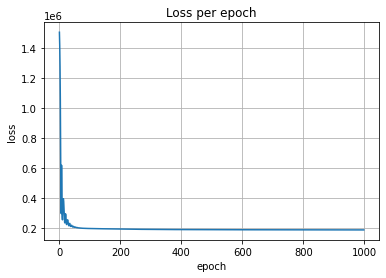

In [ ]:
# Plot the loss function
fig, ax = plt.subplots()
ax.plot(list(range(0,len(sage_loss_time_series))), sage_loss_time_series)
ax.set(xlabel='epoch', ylabel='loss',title='Loss per epoch')
ax.grid()
plt.show()

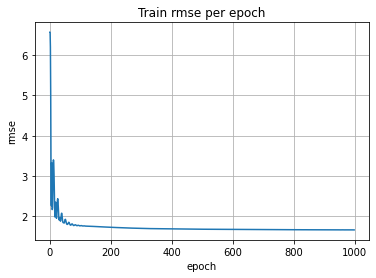

In [ ]:
# Plot the train root mean square error
fig, ax = plt.subplots()
ax.plot(list(range(0,len(sage_train_rmse_time_series))), sage_train_rmse_time_series)

ax.set(xlabel='epoch', ylabel='rmse',
       title='Train rmse per epoch')
ax.grid()


plt.show()

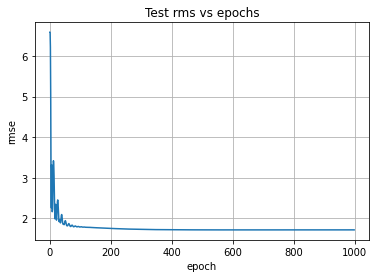

In [ ]:
# Plot the test root mean square error
fig, ax = plt.subplots()
ax.plot(list(range(0,len(sage_test_rmse_time_series))), sage_test_rmse_time_series)

ax.set(xlabel='epoch', ylabel='rmse',
       title='Test rms vs epochs')
ax.grid()


plt.show()

In [ ]:
print(f'After {epoch+1:03d}, for the GNN with GraphSAGE layer the final loss is: {loss:.4f}, the final train RMSE is: {train_rmse:.4f}, the final test RMSE is: {test_rmse:.4f} ')

After 1000, for the GNN with GraphSAGE layer the final loss is: 186730.8594, the final train RMSE is: 1.6645, the final test RMSE is: 1.7195 


##### Analyzing the model's results

In [ ]:
# estimate the test rating values

model.eval()
pred,_,_ = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(1,10)

In [ ]:
# create a dictionary with key:userId and values: estimate rating and true rating

predicted_rating={}

for i , j, k  in zip(test_data['user', 'rates', 'movie'].edge_label_index[0],test_data['user', 'rates', 'movie'].edge_label,pred): # per nome film test_data['user', 'rates', 'movie'].edge_index[1]
  userid= int(i) # userId
  j=float(j) #rating true
  k=int(round(float(k),0))# predicted rating 
  #userid=list(user_mapping.keys())[list(user_mapping.values()).index(i)]
  if userid in predicted_rating.keys():
    predicted_rating[userid].append([k,j])
  else:
    predicted_rating[userid]=[[k,j]]

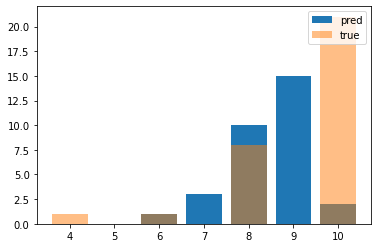

In [ ]:
#user 0 prediction vs actual rating
histo_test=[]
histo2_test=[]
for i in predicted_rating[0]:  
  histo_test.append(i[0])
  histo2_test.append(i[1])

count_test_pred=Counter(histo_test)
count_test_true=Counter(histo2_test)

keys_test_pred = count_test_pred.keys()
values_test_pred = count_test_pred.values()

keys_test_true = count_test_true.keys()
values_test_true = count_test_true.values()

plt.bar(keys_test_pred, values_test_pred,label='pred')
plt.bar(keys_test_true, values_test_true,alpha=0.5,label='true')
plt.legend(loc='upper right')


In [ ]:
# find the goodness of the predictions
count=[]
count_value=0
true_val= []
pred_val= []
for key, value in predicted_rating.items():
  count_value=0
  lenn=len(value)
  for i in value:
    if lenn >= 1:
      pred_val.append(i[0])
      true_val.append(i[1])

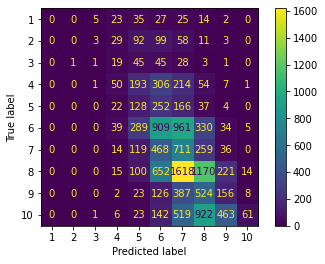

In [ ]:
# display the predictions vs true values for a visualization of the goodness of the model
confusion_matrix = metrics.confusion_matrix(true_val, pred_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1,2,3,4,5,6,7,8,9,10]) 
cm_display.plot()
plt.show()

##### Recommendation

In [ ]:
# find the coordinates of the non rated movies by users
interaction_matrix = pd.pivot_table( data=ratings,index=['userId'], columns=['movieId'],values= 'rating' ) 
coordinate_blank=np.argwhere(np.isnan(interaction_matrix.to_numpy()))
coordinate_blank=np.transpose(coordinate_blank)

In [ ]:
%%capture
# create the graph of the non connected edges
fill_data = HeteroData()

fill_data['movie'].num_nodes = len(movie_mapping)
fill_data['user'].num_nodes = len(user_mapping)


fill_data['movie'].x = torch.cat([emb, genres], dim=-1)
fill_data['user'].x = torch.eye(fill_data['user'].num_nodes)


src = coordinate_blank[0]
dst = coordinate_blank[1]

edge=[]
for i in list(range(0,len(src))):
  edge.append( [src[i],dst[i]])

edge_index= torch.tensor(edge)
edge_index=edge_index.t().contiguous()

fill_data['user', 'rates', 'movie'].edge_index = edge_index
rating = torch.zeros(len(coordinate_blank[0])).to(torch.long)

fill_data['user', 'rates', 'movie'].edge_label = rating

fill_data = T.ToUndirected()(fill_data)
del fill_data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

fill_data, fill_val_data, fill_test_data = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.0,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(fill_data)

In [ ]:
# function to find the estimate of the rating
def fill_blank_space(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,data['user', 'movie'].edge_label_index)
    return pred

In [ ]:
fill_data['user', 'rates', 'movie'].edge_label,_,_ = fill_blank_space(fill_data)

In [ ]:
predicted_rating ={}

In [ ]:
# create a dictionary with key:userId and values: estimate rating and movieId

for i , j, k  in zip(fill_data['user', 'rates', 'movie'].edge_label_index[0],fill_data['user', 'rates', 'movie'].edge_label_index[1],fill_data['user', 'rates', 'movie'].edge_label):
  userid= int(i)  # userId
  movieid=int(j)
  movieid= movies.title[movies['movieId']==movieid].values[0] #movieId
  k=round(float(k),2)# predicted rating
  if userid in predicted_rating.keys():
    predicted_rating[userid].append([k,movieid])
  else:
    predicted_rating[userid]=[[k,movieid]]


In [ ]:
# sorting the estimate rating for the recommendation
for key, value in predicted_rating.items():
  predicted_rating[key]= sorted(predicted_rating[key], key=itemgetter(0),reverse=True)

In [ ]:
# function to find the movies to recommend to the user
'''
The function parameters are: userid -> is the user Id 
                             num_movie -> number of movies to recommend
'''

def rand_matrix_fact_recsys(userid,num_movie):
  return predicted_rating[userid][0:num_movie]

In [ ]:
rand_matrix_fact_recsys(0,10)

[[9.77, 'Doctor Zhivago (1965)'],
 [9.66, 'Some Like It Hot (1959)'],
 [9.62, 'Roman Holiday (1953)'],
 [9.61, 'To Catch a Thief (1955)'],
 [9.6, 'Indian in the Cupboard, The (1995)'],
 [9.59, 'Seven Samurai (Shichinin no samurai) (1954)'],
 [9.58, 'On the Waterfront (1954)'],
 [9.57, 'Mary Poppins (1964)'],
 [9.56, 'Apartment, The (1960)'],
 [9.53, 'For a Few Dollars More (Per qualche dollaro in più) (1965)']]